# Creating optogenetic stimuli

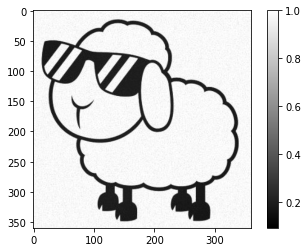

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Stimulation images should be the same shape as the stimulation array
# (otherwise they are stretched into the right dimensions), and
# should be in the range of (0,1) - min/max light intensity
img = np.array(Image.open('sheep.jpeg').convert('L')) / 255
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()

# The OptogeneticArrayImageStimulus experiment expects 2D .npy arrays as input
np.save('optogenetic_stimuli/sheep.npy',img)
np.save('optogenetic_stimuli/sheep_inverted.npy',1-img)

# Running experiments

## Mozaik

Read the [Mozaik README](https://github.com/CSNG-MFF/mozaik) for installation and how to run Mozaik experiments locally on your computer.

## Running experiments through Slurm
To run the model through Slurm (which we use to schedule jobs on the cluster), run:

`python run_model_slurm.py run.py nest param/defaults`

You can see the jobs currently running on the cluster with `squeue`, summarized info about jobs with `sinfo`, and cancel your jobs with `scancel job_id` (e.g. `scancel 237444`). Naturally, you can only cancel your own jobs. 

The script `run_model_slurm.py` has several useful options for setting up the Slurm job to run the experiment. I mostly only change the job name, and the `--exclude` parameter, where you can specify where your job should not run. If you know you'll be running a job that takes a long time (4h+), please schedule it such that you'll leave a node or so empty, unless it's the evening or the weekend.

## Modifying the experiments

You can modify the basic runscript in `run.py`, and the experiment parameters in `experiments.py`. 

At first, try to limit your run to only a few images! Because of the structure of the Mozaik framework, all the numpy arrays with the optogenetic stimulation data are generated before any experiment is run, and thus the runs can be quite memory intensive.

## Changing model parameters

If you'll need to, you can change the model parameters dynamically in the `run_model_slurm.py` file. As an example, you can do:
```
CombinationParameterSearch(
    SlurmSequentialBackend(
        num_threads=16,
        num_mpi=1,
        path_to_mozaik_env="/home/rozsa/virt_env/mozaik/bin/activate",
        slurm_options=slurm_options,
    ),  
    {   
        'pynn_seed': [520,1024,2240],
    },
).run_parameter_search()
```

Then the model will run 3x in parallel with the same experiment, but with different random seeds. To access nested parameters, use this notation: `'sheets.l4_cortex_exc.params.cell.params.tau_m': [8,9]`

# Viewing experiment results

## Results folder
The results are stored in folder with following the naming format:

```
datetime[parameter_dir_name]CombinationParamSearch{parameter_names_and_values}/
modelname_ParameterSearch_____paramname1:paramvalue_paramname2:paramvalue
```

For example: 
```
20230131-135335[param.defaults]CombinationParamSearch{trial:[1]}/
SelfSustainedPushPull_ParameterSearch_____trial:1
```

## Run log

The log file of the run is stored in the main result folder under the name `slurm_jobid.out`:

`20230131-135335[param.defaults]CombinationParamSearch{trial:[1]}/slurm_237566.out`

This will contain all logging messages from the run, as well as any errors that happened during it. If your run is successful, the end of your log file should look something like this:

```
0    Stimulus 1/1 finished. Memory usage: 12825MB
0    Experiment 1/1 finished
0    Total simulation run time: 118s
0    Simulator run time: 73s (62%) 
0    Mozaik run time: 44s (37%) 
```

## Reading experiment data

In [2]:
from mozaik.storage.datastore import PickledDataStore
from parameters import ParameterSet
from mozaik.storage.queries import param_filter_query
from mozaik.tools.distribution_parametrization import load_parameters
import logging
import sys
from mozaik.storage.queries import *
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
from mozaik.storage.datastore import DataStoreView

# Path to the experiment DataStore
# Substitute this path with the path of your own run!
path = "20230203-174506[param.defaults]CombinationParamSearch{trial:[1]}/SelfSustainedPushPull_ParameterSearch_____trial:1"

data_store = PickledDataStore(
    load=True,
    parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
    replace=False,
)

# We can query the DataStore for the results we want
# It returns a DataStoreView, a slice of the DataStore
dsv = param_filter_query(data_store, st_direct_stimulation_name="OpticalStimulatorArrayChR", sheet_name="V1_Exc_L2/3")
dsv.print_content()
print(dsv.get_stimuli()[0])

INFO:Mozaik:DSV info:
INFO:Mozaik:   Number of recordings: 4
INFO:Mozaik:     InternalStimulus : 4
INFO:Mozaik:   Number of ADS: 0
{"module_path" :"mozaik.stimuli","direct_stimulation_name":'OpticalStimulatorArrayChR', "direct_stimulation_parameters":MozaikExtendedParameterSet({'size': 3000, 'spacing': 10.0, 'depth_sampling_step': 10, 'light_source_light_propagation_data': 'light_scattering_radial_profiles_lsd10.pickle', 'update_interval': 1, 'stimulating_signal': 'mozaik.sheets.direct_stimulator.stimulating_pattern_flash', 'stimulating_signal_parameters': {'shape': 'image', 'intensity': 1, 'duration': 150, 'onset_time': 50, 'offset_time': 100, 'image_path': 'optogenetic_stimuli/sheep.npy'}, 'sheet_list': ['V1_Exc_L2/3', 'V1_Inh_L2/3'], 'sheet_intensity_scaler': [1.0, 0.0], 'sheet_transfection_proportion': [1.0, 1.0]}), "duration":150, "frame_duration":150, "name":'InternalStimulus', "trial":0}


Image path: optogenetic_stimuli/sheep.npy


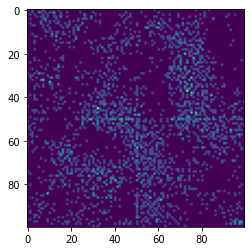

Image path: optogenetic_stimuli/sheep_inverted.npy


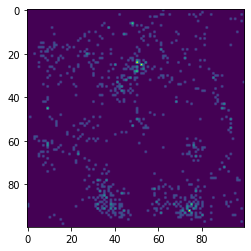

In [3]:
def retrieve_ds_param_values(dsv, param_name):
    l=[]
    for s in dsv.get_stimuli():
        if MozaikParametrized.idd(s).direct_stimulation_parameters != None:
            l.append(MozaikParametrized.idd(s).direct_stimulation_parameters.stimulating_signal_parameters[param_name])
    return sorted(list(set(l)))

def fetch_ds_dsv(dsv, params, remove_direct_stim_params=False):
    stims = dsv.get_stimuli()
    segs = dsv.get_segments()
    dsv_out = DataStoreView(ParameterSet({}), dsv.full_datastore)
    for i in range(len(stims)): 
        s = ParameterSet(str(stims[i]).replace("MozaikExtended",""))
        s = ParameterSet(str(s))["direct_stimulation_parameters"]
        if s == None:
            continue
        s = ParameterSet(s)["stimulating_signal_parameters"]
        if params.items() <= s.items():
            dsv_out.block.segments.append(segs[i])
            if remove_direct_stim_params:
                p = load_parameters(segs[i].annotations['stimulus'].replace("MozaikExtended",""))
                p.direct_stimulation_parameters = None
                segs[i].annotations['stimulus'] = str(p)
    return dsv_out

def get_st_ids(dsv):
    assert len(dsv.sheets()) == 1
    return [s for s in dsv.get_segments() if len(s.spiketrains) > 0][0].get_stored_spike_train_ids()

def get_s(dsv, s_res=None):
    """
    Retrieve positions for all neurons in DataStoreView
    """
    if s_res == None:
        s_res = 1
    st_ids = get_st_ids(dsv)
    sheet = dsv.sheets()[0]
    pos = dsv.get_neuron_positions()[sheet]
    posx = (pos[0, dsv.get_sheet_indexes(sheet, st_ids)] / s_res * 1000).astype(int)
    posy = (pos[1, dsv.get_sheet_indexes(sheet, st_ids)] / s_res * 1000).astype(int)
    posx -= min(posx)
    posy -= min(posy)
    return posx, posy

def get_t(dsv, t_res=None):
    """
    Retrieve spike times for all neurons in DataStoreView
    """
    if t_res == None:
        t_res = 1
    st_ids = get_st_ids(dsv)
    segs = [s for s in dsv.get_segments() if len(s.spiketrains) > 0]
    t = [[] for i in range(len(st_ids))]
    time_passed = 0
    for i in range(len(segs)):
        if len(segs[i].spiketrains) == 0:
            continue
        sts = segs[i].get_spiketrains()
        for j in range(len(sts)): 
            t[j].extend(list((sts[j].magnitude / t_res).astype(int) + time_passed))
        time_passed += int((sts[0].t_stop.magnitude - sts[0].t_start.magnitude) / t_res)
    return t

def get_st(dsv, s_res=None, t_res=None):
    """
    Retrieve positions and spike times for all neurons in DataStoreView
    """
    posx,posy = get_s(dsv,s_res)
    t = get_t(dsv,t_res)
    return posx, posy, t

def gen_spike_video(dsv, s_res=None, t_res=None, min_t=0, max_t=sys.maxsize):
    """
    Create a 'video' (3D array - space x space x time) from recorded spikes.
    s_res and t_res define the bin size into which the spikes are pooled
    The maximum space and time dimensions are defined by neuron coordinates
    and maximum time either by max_t or the maximum spike time.
    
    Parameters
    ----------
    dsv : DataStoreView
             DataStoreView containing a single recording
    s_res : int (um)
             Spatial bin size
    t_res : int (ms)
             Time bin size    
    """
    
    # Enforce that results can only come from a single sheet
    assert len(dsv.sheets()) == 1
    
    # Get neuron positions and spike times for each neuron
    posx, posy, t = get_st(dsv, s_res, t_res)
    
    # Filter out spike times < min_t and > max_t
    min_t=min_t//t_res
    max_t=max_t//t_res
    for i in range(len(t)):
        t[i] = [st-min_t for st in t[i] if st >= min_t and st < max_t]

    # Create 3D spike histogram
    A = np.zeros((max(posx)+1, max(posy)+1,max([v for l in t for v in l])+1))
    for i in range(len(t)):
        for st in t[i]:
            A[posx[i],posy[i],st] += 1

    # Output will be the mean firing rate (Hz) in each bin       
    A = A / t_res * 1000
    return A

# Plot the mean activity across the entire recording, each stimulus separately
image_paths = retrieve_ds_param_values(dsv, "image_path")
for im_path in image_paths:
    print("Image path:",im_path)
    dsv2 = fetch_ds_dsv(dsv,{"image_path": im_path})
    A = gen_spike_video(dsv2, s_res=30, t_res=5)
    # Plot the mean activity across the entire recording 
    plt.imshow(A.mean(axis=2))
    plt.show()